In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization data
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Loading Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
df = pd.read_csv("/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


Data Preparation

In [42]:
df.isna().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [43]:
df = df.dropna()
df.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [44]:
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


In [36]:
#Vincent
#Convert into Hour/Add a new col
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df['hr-dd-mm-yyyy'] = df['datetime'].dt.strftime('%H-%d-%m-%Y')
df = df.rename(columns={'hr-dd-mm-yyyy': 'hr'})

#Set datetime as index
df.set_index('datetime', inplace=True)
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date,hr
datetime,,,,,,,,,,
2011-12-31 07:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,07-31-12-2011
2011-12-31 15:50:00,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,15-31-12-2011
2011-12-31 16:59:00,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31,16-31-12-2011
2011-12-31 17:00:00,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,17-31-12-2011
2012-01-01 04:16:00,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,04-01-01-2012
...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:56:00,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30,23-30-03-2021
2021-03-30 23:57:00,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30,23-30-03-2021
2021-03-30 23:58:00,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30,23-30-03-2021


In [12]:
#Vincent
#Group by hour
g1 = pd.DataFrame(df['Close'].resample('H').mean())

#Check and Drop NA values
g1 = g1.dropna()
g1.isna().sum()

Close    0
dtype: int64

In [13]:
#Vincent
#Grouped data by hour in order 
g1

,Close
datetime,
2011-12-31 07:00:00,4.390000
2011-12-31 15:00:00,4.390000
2011-12-31 16:00:00,4.570000
2011-12-31 17:00:00,4.580000
2012-01-01 04:00:00,4.580000
...,...
2021-03-30 20:00:00,58678.720333
2021-03-30 21:00:00,58709.001000
2021-03-30 22:00:00,58788.207333


In [45]:
grouped_df = df.groupby('date', as_index = False).mean()
grouped_df

,date,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,1.325342e+09,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
1,2012-01-01,1.325427e+09,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2,2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
3,2012-01-03,1.325605e+09,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
4,2012-01-04,1.325682e+09,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...,...,...
3371,2021-03-27,1.616846e+09,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
3372,2021-03-28,1.616933e+09,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
3373,2021-03-29,1.617019e+09,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819
3374,2021-03-30,1.617106e+09,58347.805624,58371.955310,58323.956690,58349.357087,2.363999,138231.241926,58346.912268


In [49]:
grouped_df= grouped_df[['Timestamp', 'Close']]
grouped_df

,Timestamp,Close
0,1.325342e+09,4.482500
1,1.325427e+09,4.806667
2,1.325535e+09,5.000000
3,1.325605e+09,5.252500
4,1.325682e+09,5.223333
...,...,...
3371,1.616846e+09,55195.415367
3372,1.616933e+09,55835.012863
3373,1.617019e+09,56915.629993
3374,1.617106e+09,58349.357087


In [72]:
grouped_df

,Timestamp,Close,CS
0,1.325342e+09,4.482500,0.000002
1,1.325427e+09,4.806667,0.000008
2,1.325535e+09,5.000000,0.000011
3,1.325605e+09,5.252500,0.000015
4,1.325682e+09,5.223333,0.000015
...,...,...,...
3371,1.616846e+09,55195.415367,0.912935
3372,1.616933e+09,55835.012863,0.923515
3373,1.617019e+09,56915.629993,0.941390
3374,1.617106e+09,58349.357087,0.965105


In [127]:
X_train.shape

(2676, 1)

In [140]:
X = grouped_df[['Timestamp', 'CS']]
y = grouped_df['CS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

time_step = 30
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

(2700, 2)
(2700, 1)
(676, 2)
(676, 1)


In [135]:
time_step = 30

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, data_scaled, test_size=0.3, shuffle=False)

array([[2.49498698e-06],
       [7.85714133e-06],
       [1.10551357e-05],
       ...,
       [1.10428706e-01],
       [1.11364396e-01],
       [1.05117886e-01]])

In [92]:
X = grouped_df[['Timestamp', 'Close']].values
y = grouped_df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(y)

time_step = 30
X_train = []
y_train = []
for i in range(time_step, data_scaled.shape[0]):
    X_train.append(data_scaled[i-time_step:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Reshape the input data for the RNN
X_train = np.reshape(X_train, (X_train.shape[0], time_step, 1))
X_test = np.reshape(X_test, (X_test.shape[0], time_step, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape[1])
print(y_train.shape)
print(X_test.shape[1])
print(y_test.shape)

30
(2676,)
30
(670,)


In [107]:
y_train

array([2.00701715e-05, 2.12946349e-05, 2.41021256e-05, ...,
       1.42953013e-01, 1.42708130e-01, 1.38053400e-01])

In [141]:
# Build
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(time_step, 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(32))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.summary()

model.compile(optimizer='adam', loss='mae', metrics='mape') #mape: Mean Absolute Percentage Error
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, steps_per_epoch = 64, validation_data=(X_test,y_test), callbacks=[early_stop])

# Evaluate model on test set
test_loss, test_mape = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAPE:", test_mape)

del model



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 30, 64)            4224      
                                                                 
 dropout_15 (Dropout)        (None, 30, 64)            0         
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


ValueError: ignored

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

X = grouped_df[['Timestamp', 'Close']].values
y = grouped_df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(y)

grouped_df['CS'] = scaler.fit_transform(grouped_df['Close'].values.reshape(-1,1))

time_step = 30
X = []
y = []
for i in range(time_step, len(grouped_df)):
    X.append(grouped_df['CS'][i-time_step:i])
    y.append(grouped_df['CS'][i])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (len(X_train), time_step, 1))
X_test = np.reshape(X_test, (len(X_test), time_step, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape[1])
print(y_train.shape)
print(X_test.shape[1])
print(y_test.shape)

30
(2676,)
30
(670,)


In [80]:
y_test

array([0.14122541, 0.14330977, 0.14104219, 0.1297786 , 0.12848656,
       0.12814305, 0.13124966, 0.1312859 , 0.12893455, 0.12928496,
       0.13055746, 0.13286844, 0.13507151, 0.13811227, 0.14430161,
       0.150389  , 0.15271506, 0.15133603, 0.15125275, 0.15464806,
       0.16207413, 0.17734429, 0.1777021 , 0.1793171 , 0.18708361,
       0.2090698 , 0.19518176, 0.19310182, 0.19595716, 0.19081572,
       0.17671932, 0.17038852, 0.18760472, 0.19445507, 0.18421595,
       0.18876378, 0.18704517, 0.19502112, 0.20692956, 0.20917492,
       0.1915523 , 0.19157191, 0.1889918 , 0.17953651, 0.17227566,
       0.17123004, 0.15834988, 0.1662229 , 0.17316898, 0.17660888,
       0.17491186, 0.1728058 , 0.16652936, 0.16043898, 0.16564232,
       0.16162484, 0.1608609 , 0.15683717, 0.15773995, 0.15775435,
       0.16299991, 0.16676122, 0.17321282, 0.17833457, 0.17892688,
       0.19306925, 0.19442797, 0.19366699, 0.19515695, 0.19545882,
       0.19147195, 0.18815455, 0.18843208, 0.18417393, 0.17261

In [81]:
model = Sequential()

model.add(SimpleRNN(units=32, input_shape=(time_step, 1), activation='tanh', return_sequences=True))
model.add(SimpleRNN(8, activation='tanh'))
model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 30, 32)            1088      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 8)                 328       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='adam', loss='mae', metrics='mape') #mape: Mean Absolute Percentage Error

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, steps_per_epoch = 32, validation_data=(X_test,y_test))

# Evaluate model on test set
test_loss, test_mape = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAPE:", test_mape)

keras.backend.clear_session()
del model

Epoch 1/50
71/84 [========================>.....] - ETA: 0s - loss: 0.0017 - mape: 735.5181

KeyboardInterrupt: ignored

21/21 [==============================] - 1s 4ms/step


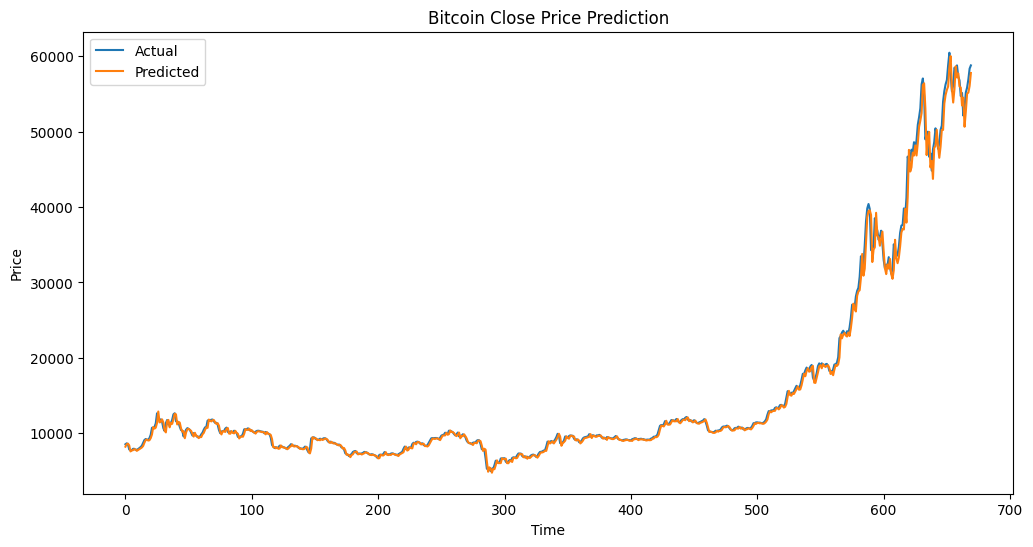

In [61]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Bitcoin Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

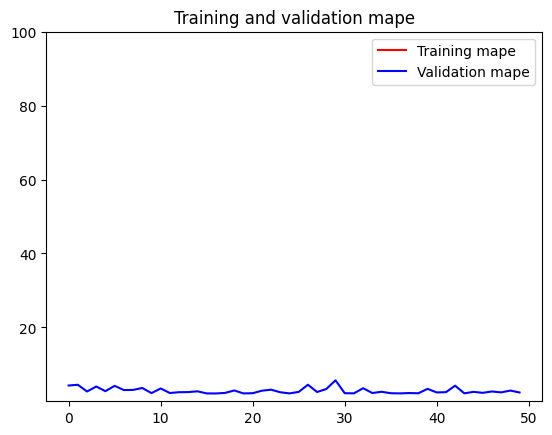

In [63]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

Train and Test Split

In [46]:
from sklearn.model_selection import train_test_split

# Train-test-validation split
train,_=train_test_split(grouped_df,test_size=0.3)
print(train.shape,test.shape)

(2363, 9) (507, 9)


In [47]:
train_size = int(len(grouped_df) * 0.7)
test_size = len(grouped_df) - train_size
df_train = grouped_df.iloc[0:train_size, :]
df_test = grouped_df.iloc[train_size:len(grouped_df), :]
print("Train size: {}, Test size: {}". format(len(df_train), len(df_test)))

Train size: 2363, Test size: 1013


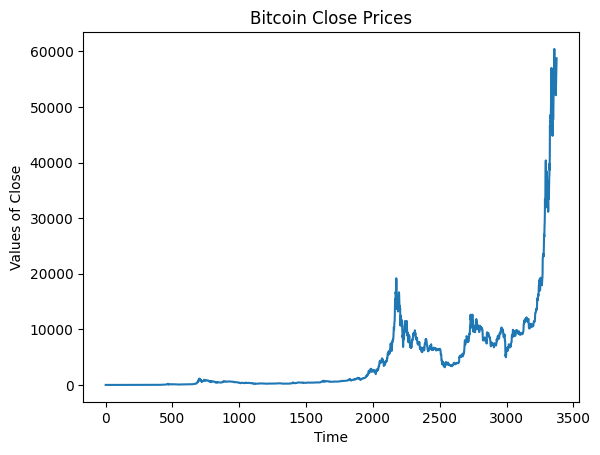

In [19]:
data_plot = grouped_df.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Prices")
plt.show()

In [21]:
ddd = df_train.loc[:, ["Close"]].values

#reshape
ddd = ddd.reshape(-1, 1)

#change type
ddd = ddd.astype("float32")
ddd.shape

(2363, 1)

In [22]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(ddd)
data_scaled

array([[7.8616577e-06],
       [2.4757654e-05],
       [3.4834418e-05],
       ...,
       [3.4795767e-01],
       [3.5090598e-01],
       [3.3122343e-01]], dtype=float32)

In [23]:
# Creating a data structure with 10 time_step and 1 output
X_train = []
y_train = []
time_step = 30
for i in range(time_step, data_scaled.shape[0]):
    X_train.append(data_scaled[i-time_step:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (2333, 30)
y_train shape:  (2333,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [27]:
X_test = []
y_test = []
for i in range(data_scaled.shape[0]-time_step, data_scaled.shape[0]):
    X_test.append(data_scaled[i-time_step:i, 0])
    y_test.append(data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_test shape:  (30, 30)
y_test shape:  (30,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
X_test = []
y_test = []
for i in range(time_step, len(df_test)):
    X_test.append(test[i-time_step:i, 0])
    y_test.append(df_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

InvalidIndexError: ignored